# Imports

In [73]:
# try:
#   # This command only in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

import os
import re
import pickle
from collections import Counter
import zipfile

import requests
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
### ImageDataGenerator is deprecated; instead, use tf.keras.utils.image_dataset_from_directory
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt


In [74]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


# Get data

In [75]:
# Get project files
answer = input("Download and unzip the files?")
if answer.strip().lower() == 'yes':
    # !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
    URL = 'https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip'
    filename = os.path.basename(URL)
    r = requests.get(URL)
    with open(filename, 'wb') as f:
        f.write(r.content)
    ###
    # !unzip cats_and_dogs.zip
    with zipfile.ZipFile(filename, 'r') as zip:
        zip.extractall()
    print('[INFO] Downloaded and unzipped')
else:
    print('[INFO] Skipped.')


[INFO] Skipped.


In [76]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))
def print_count(label, count):
    print(f"[INFO] {label}: {count}")
print_count('train', total_train)
print_count('val', total_val)
print_count('test', total_test)

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

[INFO] train: 2001
[INFO] val: 1001
[INFO] test: 2


In [77]:
# 3

train_ds = image_dataset_from_directory(
    'cats_and_dogs/train'
)
class_names = train_ds.class_names
print(train_ds.class_names)

validation_ds = image_dataset_from_directory(
    'cats_and_dogs/validation'
)

test_ds = image_dataset_from_directory(
    'cats_and_dogs/test'
)

# train_image_generator = None
# validation_image_generator = None
# test_image_generator = None

# train_data_gen = None
# val_data_gen = None
# test_data_gen = None


Found 2000 files belonging to 2 classes.
['cats', 'dogs']
Found 1000 files belonging to 2 classes.
Found 50 files belonging to 2 classes.


(32, 256, 256, 3)
tf.Tensor(
[[[[1.90950729e+02 1.86950729e+02 1.87950729e+02]
   [1.91955078e+02 1.87955078e+02 1.88955078e+02]
   [1.92351562e+02 1.88351562e+02 1.89351562e+02]
   ...
   [2.16740234e+02 2.00740234e+02 2.01367188e+02]
   [2.18131561e+02 2.02131561e+02 2.02555389e+02]
   [2.24802734e+02 2.08802734e+02 2.08802734e+02]]

  [[1.80304688e+02 1.76304688e+02 1.77304688e+02]
   [1.81134766e+02 1.77134766e+02 1.78134766e+02]
   [1.81563278e+02 1.77563278e+02 1.78563278e+02]
   ...
   [2.06452347e+02 1.90452347e+02 1.91079300e+02]
   [2.06576172e+02 1.90576172e+02 1.91000000e+02]
   [2.11761719e+02 1.95761719e+02 1.95761719e+02]]

  [[1.80554688e+02 1.76554688e+02 1.77554688e+02]
   [1.81384766e+02 1.77384766e+02 1.78384766e+02]
   [1.82148438e+02 1.78148438e+02 1.79148438e+02]
   ...
   [2.10147781e+02 1.94147781e+02 1.94774734e+02]
   [2.10776566e+02 1.94776566e+02 1.95200394e+02]
   [2.16316406e+02 2.00316406e+02 2.00316406e+02]]

  ...

  [[1.60081390e+02 1.44409515e+02 1.1

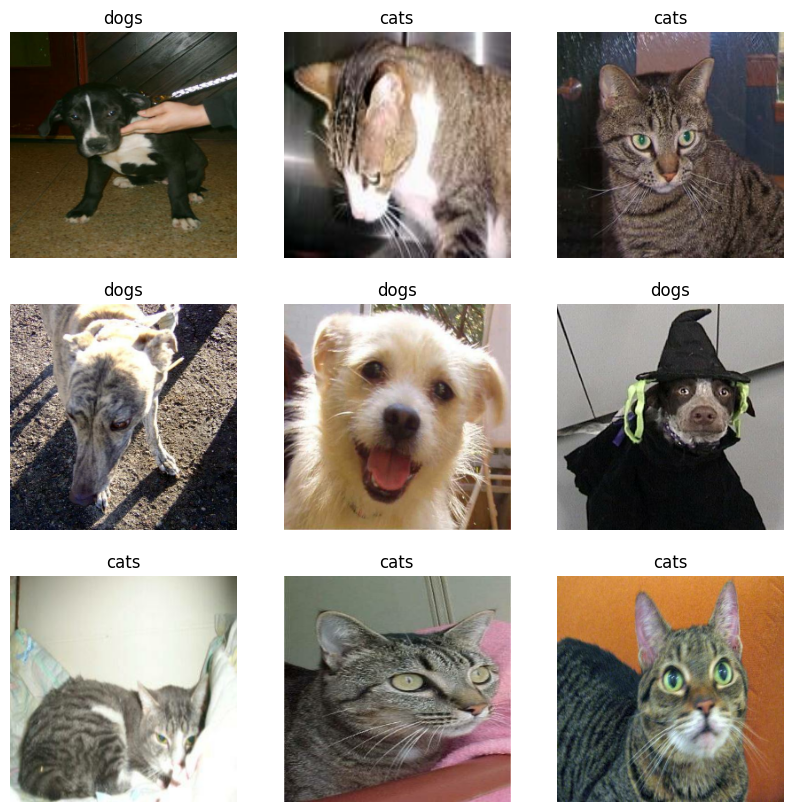

In [78]:
# # 4
# def plotImages(images_arr, probabilities = False):
#     fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
#     if probabilities is False:
#       for img, ax in zip( images_arr, axes):
#           ax.imshow(img)
#           ax.axis('off')
#     else:
#       for img, probability, ax in zip( images_arr, probabilities, axes):
#           ax.imshow(img)
#           ax.axis('off')
#           if probability > 0.5:
#               ax.set_title("%.2f" % (probability*100) + "% dog")
#           else:
#               ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
#     plt.show()

# sample_training_images, _ = next(train_data_gen)
# plotImages(sample_training_images[:5])

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# for images1, labels1 in train_ds.take(1):
#   print(images1)
#   break

img1, lbl1 = next(iter(train_ds))
print(img1.shape)
print(img1)


# Model

In [79]:
# 5
# train_image_generator = None

### Standardise the data
# [0, 255] -> [0, 1]

num_classes = 2

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    # layers.RandomCrop(220, 220),
    # layers.RandomZoom((0.1,0.2), (0.1,0.2))
])


model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])


In [80]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)


In [81]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50
)


Epoch 1/50


63/63 [==============================] - 16s 200ms/step - loss: 0.7834 - accuracy: 0.5095 - val_loss: 0.6916 - val_accuracy: 0.5060
Epoch 2/50
63/63 [==============================] - 13s 205ms/step - loss: 0.6860 - accuracy: 0.5540 - val_loss: 0.6926 - val_accuracy: 0.5260
Epoch 3/50
63/63 [==============================] - 14s 210ms/step - loss: 0.6731 - accuracy: 0.6035 - val_loss: 0.6931 - val_accuracy: 0.5910
Epoch 4/50
63/63 [==============================] - 13s 204ms/step - loss: 0.6543 - accuracy: 0.6300 - val_loss: 0.7411 - val_accuracy: 0.5500
Epoch 5/50
63/63 [==============================] - 13s 208ms/step - loss: 0.6476 - accuracy: 0.6290 - val_loss: 0.6943 - val_accuracy: 0.5590
Epoch 6/50
63/63 [==============================] - 14s 215ms/step - loss: 0.6412 - accuracy: 0.6540 - val_loss: 0.6738 - val_accuracy: 0.6090
Epoch 7/50
63/63 [==============================] - 14s 213ms/step - loss: 0.6308 - accuracy: 0.6745 - val_loss: 0.6791 - val_accuracy: 0.5950
Epoch 8/50

In [82]:
history

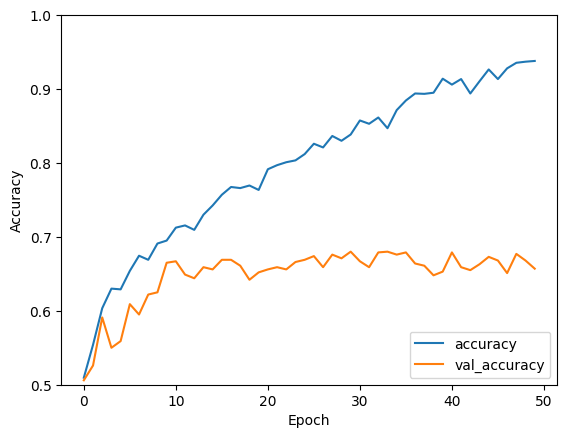

In [83]:
# # 9
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [84]:
# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(test_loss)
print(f"[INFO] Test accuracy: {test_acc}")


2/2 - 0s - loss: 1.0513 - accuracy: 0.7000 - 140ms/epoch - 70ms/step
1.0512778759002686
[INFO] Test accuracy: 0.699999988079071


In [85]:
!pip install Pillow

In [86]:
image_path = 'cats_and_dogs/train/cats/cat.0.jpg'
# image_path = 'cats_and_dogs/test/cats/5.jpg'

import PIL
from PIL import Image

image = tf.keras.utils.load_img(image_path)
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [ ]:
image_path = 'cats_and_dogs/train/cats/cat.0.jpg'
# image_path = 'cats_and_dogs/test/cats/5.jpg'


# image = tf.keras.utils.load_img(image_path)
image = Image.open(image_path)
# image = image.resize((250,250))
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

print(input_arr.shape)

# input_arr_proc = tf.expand_dims(input_arr, axis=0)

predictions = model.predict(input_arr)

(1, 250, 250, 3)


ValueError: in user code:

    File "c:\Users\evgen\.conda\envs\cat-and-dog-image-classifier3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\evgen\.conda\envs\cat-and-dog-image-classifier3\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\evgen\.conda\envs\cat-and-dog-image-classifier3\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\evgen\.conda\envs\cat-and-dog-image-classifier3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\evgen\.conda\envs\cat-and-dog-image-classifier3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\evgen\.conda\envs\cat-and-dog-image-classifier3\lib\site-packages\keras\engine\input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_16" "                 f"(type Sequential).
    
    Input 0 of layer "dense_16" is incompatible with the layer: expected axis -1 of input shape to have value 28800, but received input with shape (None, 26912)
    
    Call arguments received by layer "sequential_16" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 250, 250, 3), dtype=float32)
      • training=False
      • mask=None
